In [1]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


Download https://drive.google.com/drive/folders/1BZFez3OFs7QMzeDUz-8E0SgnRy227pnG

Unzip

!mkdir data !tar -xf inno_stats.tar.gz -C ./data

In [3]:
g_9 = pd.read_csv('./data/09_groups.csv')
g_10 = pd.read_csv('./data/10_groups.csv')
g_11 = pd.read_csv('./data/11_groups.csv')
g_9.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [4]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


In [5]:
bad_ids = pd.read_csv('bad_ids.csv')
bad_ids.head()

,Unnamed: 0,id_card
0,0,806096
1,1,1438102
2,2,72344
3,3,427981
4,4,1528414


In [6]:
df = g_9

In [7]:
df = df[~df.id_card.isin(bad_ids.id_card.values)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38466003 entries, 0 to 42100857
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      object 
 1   id_doc    int64  
 2   id_order  float64
 3   id_card   int64  
 4   id_tov    int64  
 5   id_kontr  int64  
 6   quantity  float64
 7   sum       float64
 8   is_green  int64  
 9   id_group  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 3.2+ GB


## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

H0: discounted products buyid does not depend on the average order sum

HA: discounted products buyid does depend on the average order sum

In [8]:
avg_sum = df.groupby('id_doc')['sum'].mean()
avg_disc = df.groupby('id_doc')['is_green'].count()

ttest_ind(avg_disc.values, avg_sum.values)

Ttest_indResult(statistic=-3678.842357621653, pvalue=0.0)

P-values is low, H0 is rejected, discounted products depend on the average order sum

## Task 2
Prove that the frequency of shopping grows around the wage taking days.

In [10]:
df.date = pd.to_datetime(df.date, format='%Y-%m-%d %H:%M:%S')

receipts = df.groupby(df.date.dt.day)['id_doc'].count()

/home/IlnurMIR/.local/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


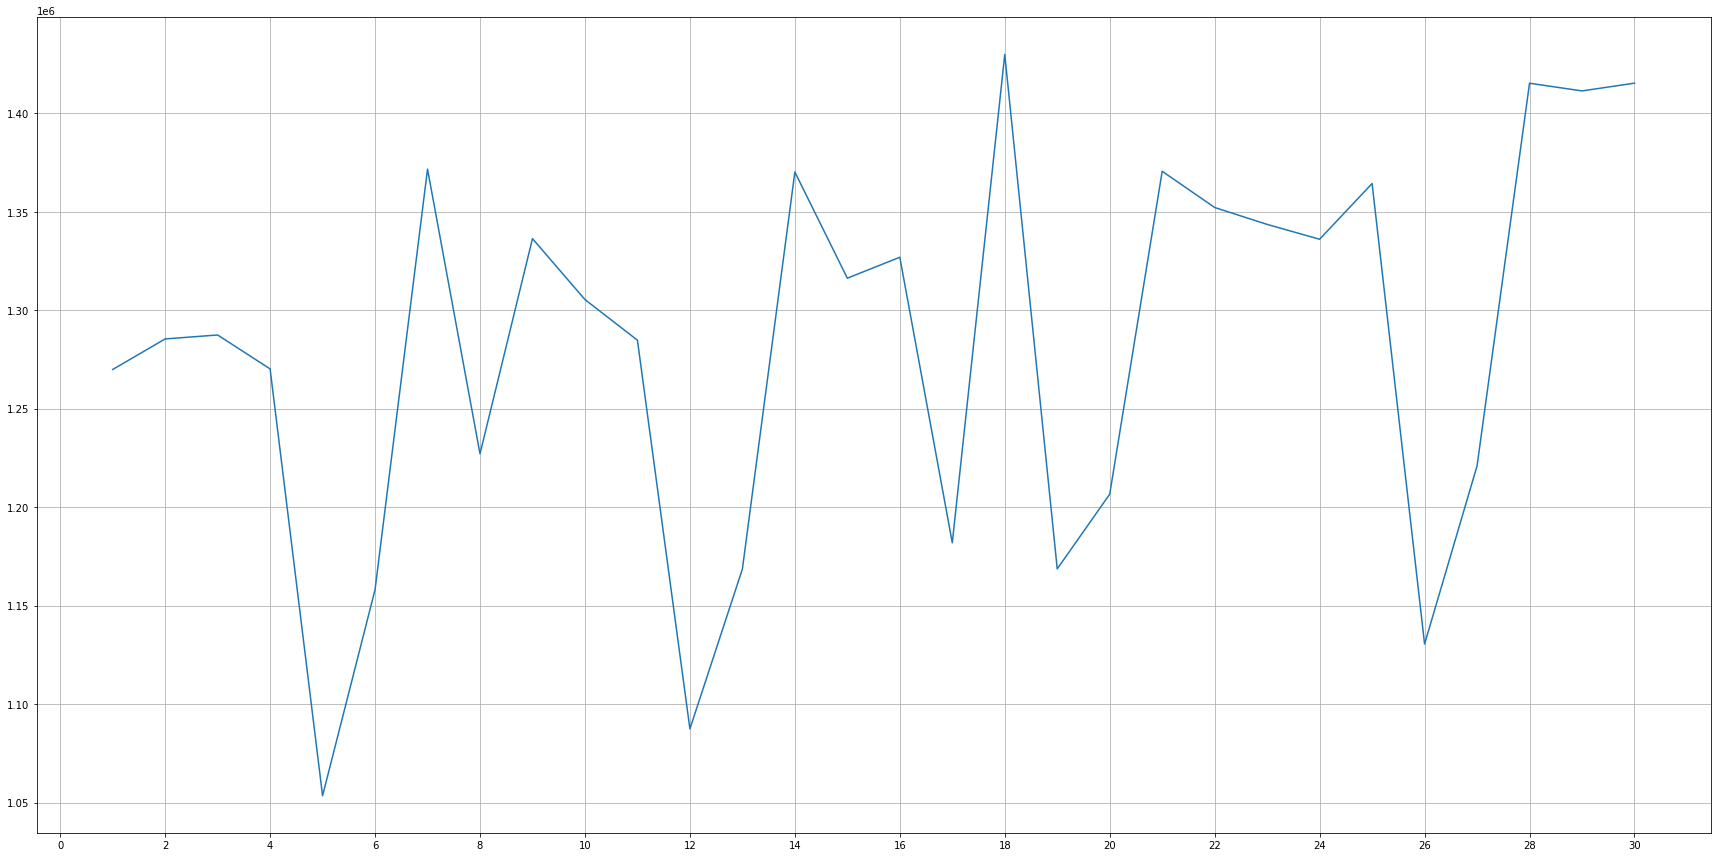

In [11]:
plt.figure(figsize=(30, 15))
plt.locator_params(axis='x', nbins=30)
plt.grid()
plt.plot(receipts)

It is seen that local minimums are at days 5, 20 and 26. 
Day of payment are 1-5, 20-25 then we can see that before those days people less buy. Also, people buy more frequently at these and aftercoming days. 

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

### Frequent buyers

Text(0, 0.5, 'Purchases')

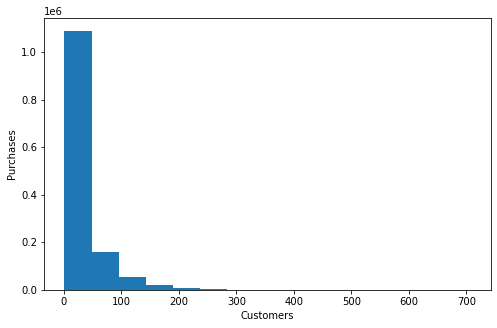

In [13]:
receipt_count = df.groupby('id_card')['id_doc'].count()

plt.figure(figsize=(8, 5))
plt.hist(receipt_count, bins=15)
plt.xlabel('Customers')
plt.ylabel('Purchases')

Text(0, 0.5, 'Purchases')

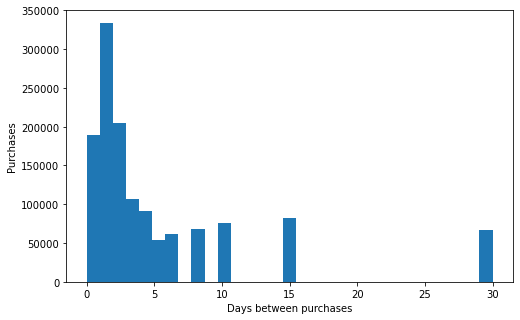

In [14]:
freqs = (1 / receipt_count[receipt_count > 0] * 30).round()

plt.figure(figsize=(8, 5))
plt.hist(freqs, bins=31)
plt.xlabel('Days between purchases')
plt.ylabel('Purchases')

Most of people purchase every day.

### Average purchase sum

In [15]:
p_sum = df.groupby('id_card')['sum'].sum()
p_sum.head()

id_card
0    3607.20
1     147.00
2    1485.00
3    4393.38
4    3905.12
Name: sum, dtype: float64

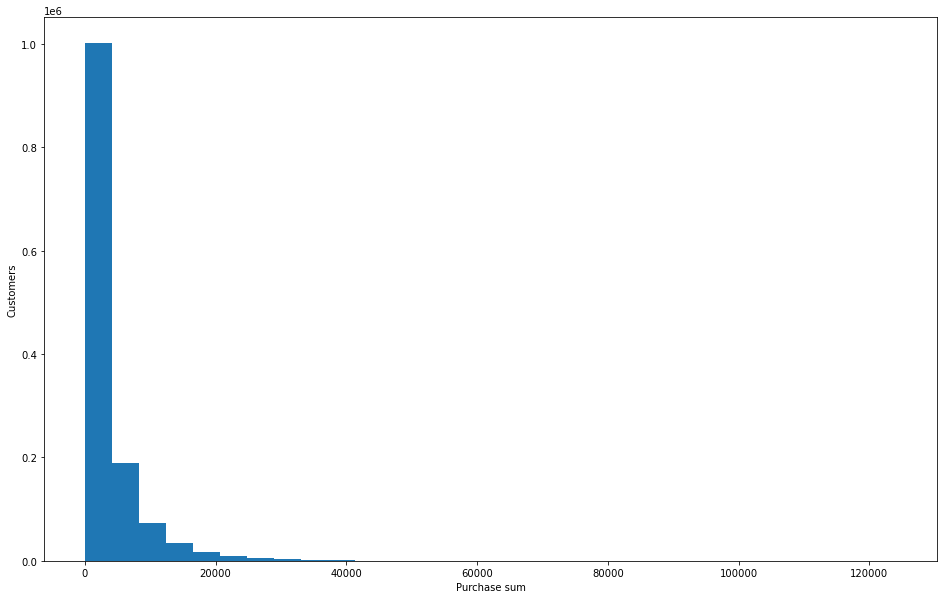

In [16]:
plt.figure(figsize=(16, 10))
plt.ylabel('Customers')
plt.xlabel('Purchase sum')
plt.hist(p_sum, bins=30);

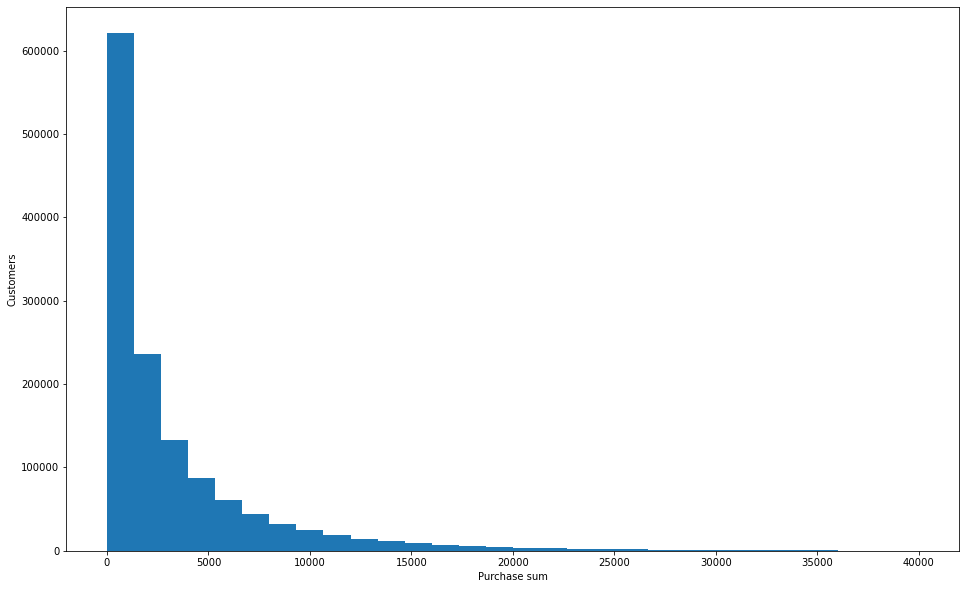

In [17]:
plt.figure(figsize=(16, 10))
plt.ylabel('Customers')
plt.xlabel('Purchase sum')
plt.hist(p_sum[p_sum < 40000], bins=30);

1000 rubles - the most popular sum in check 

## Orders amount

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fede78b04c0>]],
      dtype=object)

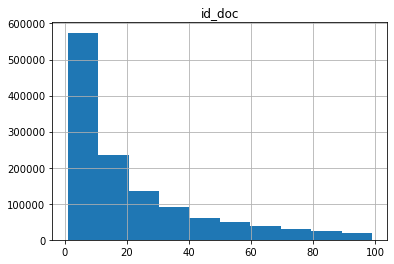

In [19]:
count = df.groupby(['id_card'])['id_doc'].count()
count[count<100].to_frame().hist()

Graph of distribution of how often people go to supermarket.

### Usual cart

Text(0, 0.5, 'Customers')

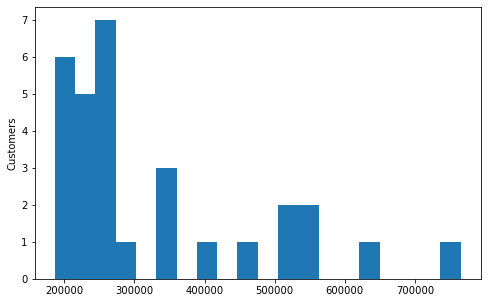

In [20]:
groups_customer = df.groupby('id_group')['id_card'].unique().apply(len)

plt.figure(figsize=(8, 5))
plt.hist(groups_customer.sort_values(ascending=False)[:30], bins=20)
plt.ylabel('Groupst')
plt.ylabel('Customers')

Text(0, 0.5, 'Customers')

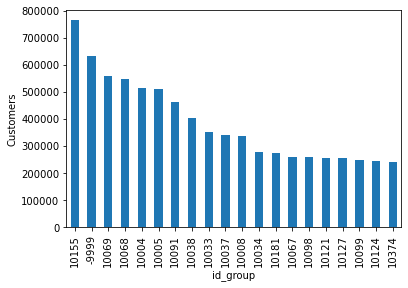

In [21]:
groups_customer = df.groupby(by=['id_group'])['id_card'].unique().apply(len)
groups_customer = groups_customer.sort_values(ascending=False)
groups_customer[:20].plot(kind='bar')

plt.ylabel('Customers')

In [22]:
sus_groups = p_g[p_g.id_group.isin(groups_customer[:20].index)]
sus_groups.drop_duplicates('id_group', 'first', inplace=True)
sus_groups['occurence'] = groups_customer[:20]
sus_groups.sort_values('occurence', ascending=False)
sus_groups[['id_group', 'name_group', 'occurence']].head()

<ipython-input-22-5ddfd5530d87>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sus_groups.drop_duplicates('id_group', 'first', inplace=True)
<ipython-input-22-5ddfd5530d87>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sus_groups['occurence'] = groups_customer[:20]


,id_group,name_group,occurence
0,10004,Кисломолочные продукты,NaN
43,10005,Творог,NaN
93,10008,"Торты, пирожные, муссы, суфле",NaN
960,10033,"Выпечка, печенье, вафли, пряники",NaN
1032,10034,"Леденцы, мармелад, халва, зефир, восточные сла...",NaN


"Кисломолочные продукты" the most popular